In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [2]:
y = np.random.randint(0,3,500)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 178
1 177
2 145


In [3]:
x = np.zeros((500,))

In [4]:
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))

In [5]:
print(x.shape,y.shape)

(500,) (500,)


In [6]:
idx= []
for i in range(3):
  idx.append(y==i)

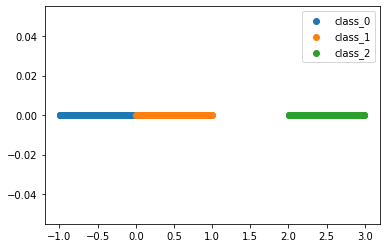

In [7]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [8]:
foreground_classes = {'class_0','class_1' }

background_classes = {'class_2'}

In [9]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
#print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
foreground 1 present at 1
background 2 present at 2
background 2 present at 3
background 2 present at 4
background 2 present at 5
background 2 present at 6
background 2 present at 7
background 2 present at 8
1 1


In [10]:
a.shape

(9,)

In [11]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,2)
    fg_idx = 0
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(9,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [12]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T
print(mosaic_list_of_images)

[[ 0.76463938  2.12341914  2.7109012  ...  2.94404184  2.8895756
   2.82571502]
 [ 0.41139511  2.81945745  2.91695731 ...  2.18303025  2.93311443
   2.41094842]
 [ 0.4272637   2.86475004  2.52067017 ...  2.52461359  2.65494489
   2.25651911]
 ...
 [-0.98969063  2.3309339   2.01248228 ...  2.75418068  2.69858295
   2.52067017]
 [-0.14443865  2.06130818  2.36961696 ...  2.28450295  2.82665534
   2.99316139]
 [-0.98969063  2.81206949  2.53790931 ...  2.7900146   2.6628118
   2.75122502]]


In [13]:
print(np.shape(mosaic_list_of_images))
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(2000, 9)
(2000,)
(2000,)


In [14]:
mosaic_label[0:6]

[1, 1, 1, 0, 1, 0]

In [15]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.array([0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([2], dtype=torch.float64)
    np.random.seed(dataset_number*10000 + i)
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(9):
      if j == give_pref:
        img = img + mosaic_dataset[i][j]*dataset_number/9
      else :
        img = img + mosaic_dataset[i][j]*(9-dataset_number)/(8*9)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [16]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 0)
avg_image_dataset_2 , labels_2,  fg_index_2 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 1)
avg_image_dataset_3 , labels_3,  fg_index_3 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 2)
avg_image_dataset_4 , labels_4,  fg_index_4 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 3)
avg_image_dataset_5 , labels_5,  fg_index_5 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 4)
avg_image_dataset_6 , labels_6,  fg_index_6 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 5)
avg_image_dataset_7 , labels_7,  fg_index_7 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 6)
avg_image_dataset_8 , labels_8,  fg_index_8 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 7)
avg_image_dataset_9 , labels_9,  fg_index_9 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 8)
avg_image_dataset_10 , labels_10,  fg_index_10 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000], fore_idx[0:1000] , 9)

test_dataset , labels , fg_index = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000], fore_idx[1000:2000] , 9)

number of correct averaging happened for dataset 0 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 1 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 2 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 3 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 4 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 5 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 6 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 7 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 8 is 1000
the averaging are done as  [1000    0]
number of correct averaging happened for dataset 9 is 1000
the averaging are done as  [1000    0]
number of correct av

In [17]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [18]:
avg_image_dataset_1[0].shape
avg_image_dataset_1[0]

tensor([2.6705, 2.6705], dtype=torch.float64)

In [19]:
l = [ labels_1, labels_2, labels_3, labels_4, labels_5, labels_6, labels_7, labels_8, labels_9, labels_10]
for i in l:
  print(np.unique(l))

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [20]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)

traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

In [21]:
testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)



In [22]:
testdata_11 = MosaicDataset(test_dataset, labels )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [23]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,2)
        # self.linear2 = nn.Linear(50,10)
        # self.linear3 = nn.Linear(10,2)

    def forward(self,x):
        # x = F.relu(self.linear1(x))
        # x = F.relu(self.linear2(x))
        x = (self.linear1(x))

        return x

In [24]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/i

In [25]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the 1000 test dataset %d: %.2f %%' % (number , 100 * correct / total))

In [31]:
def train_all(trainloader, ds_number, testloader_list):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=0.001 ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 12000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%1000 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.005:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 1000 train images: %.2f %%' % (  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi
    

In [32]:
train_loss_all=[]

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10, testloader_11]

In [33]:
train_loss_all.append(train_all(trainloader_1, 1, testloader_list))
train_loss_all.append(train_all(trainloader_2, 2, testloader_list))
train_loss_all.append(train_all(trainloader_3, 3, testloader_list))
train_loss_all.append(train_all(trainloader_4, 4, testloader_list))
train_loss_all.append(train_all(trainloader_5, 5, testloader_list))
train_loss_all.append(train_all(trainloader_6, 6, testloader_list))
train_loss_all.append(train_all(trainloader_7, 7, testloader_list))
train_loss_all.append(train_all(trainloader_8, 8, testloader_list))
train_loss_all.append(train_all(trainloader_9, 9, testloader_list))
train_loss_all.append(train_all(trainloader_10, 10, testloader_list))

--------------------------------------------------------------------------------
training on data set   1
epoch: [0 ] loss: 0.957
epoch: [1] loss: 0.944
epoch: [1001] loss: 0.866
epoch: [2001] loss: 0.866
epoch: [3001] loss: 0.866
epoch: [4001] loss: 0.866
epoch: [5001] loss: 0.866
epoch: [6001] loss: 0.866
epoch: [7001] loss: 0.866
epoch: [8001] loss: 0.866
epoch: [9001] loss: 0.866
epoch: [10001] loss: 0.866
epoch: [11001] loss: 0.866
Finished Training
Accuracy of the network on the 1000 train images: 51.10 %
unique out:  [0 1] unique pred:  [0 1]
correct:  511 total  1000
Accuracy of the network on the 1000 test dataset 1: 51.10 %
unique out:  [0 1] unique pred:  [1]
correct:  512 total  1000
Accuracy of the network on the 1000 test dataset 2: 51.20 %
unique out:  [0 1] unique pred:  [1]
correct:  512 total  1000
Accuracy of the network on the 1000 test dataset 3: 51.20 %
unique out:  [0 1] unique pred:  [1]
correct:  512 total  1000
Accuracy of the network on the 1000 test dataset 

In [34]:
%matplotlib inline

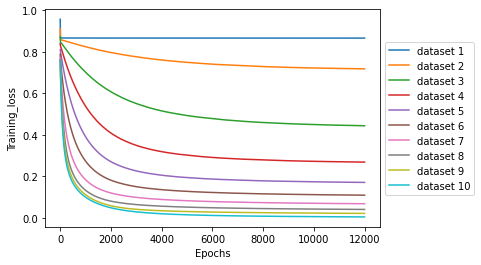

In [35]:
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="dataset "+str(i+1))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))